# Update from 24 Sept 2024:

* I don't remember where I got this code from. It runs without errors, but produces a hilariously bad result (see the actual vs predicted plot)
* If we're gonna make use of matrix profile we gotta learn what the hell it is and how the make_features function works. Or better yet, find better ways of using it instead of just calculating some features and applying a off the shelf regressor!

In [ ]:
import numpy as np
import pandas as pd
import stumpy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:


# 1. Load and prepare the data
# Assume we have a time series data in a CSV file
data = pd.read_csv('GOOG_stock_data.csv')
time_series = data['open'].values

In [3]:

# 2. Compute the matrix profile
window_size = 50  # Adjust this based on your data
matrix_profile = stumpy.stump(time_series, m=window_size)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


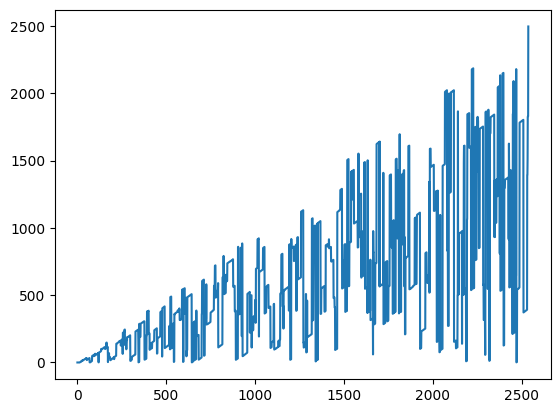

In [4]:
plt.plot(matrix_profile[:,2])

In [10]:
# WHAT is the meaning of the column index??
matrix_profile_1d = matrix_profile[:, 1]

# 3. Find motifs (recurring patterns)
motifs = stumpy.motifs(time_series, matrix_profile_1d, max_motifs=21)

/home/sigmaroles/miniconda3/envs/pytorch/lib/python3.10/site-packages/stumpy/motifs.py:351: UserWarning: The `cutoff` has been set to 0.0 and may result in little/no candidate motifs being identified.
You may consider relaxing the constraint by increasing the `cutoff` (e.g., cutoff=1).
  warnings.warn(msg)


In [11]:
motifs

(array([[0.        , 4.92823359, 5.0775799 , 5.27537082, 5.32485357,
         5.65829782, 5.77984967, 5.8261843 , 5.91508329, 5.98962862]]),
 array([[2471,    0, 2181,  537,  646, 1866, 1165, 2218, 2303, 1482]]))

## Now the usual train-test stuff, but first, gotta define features

In [7]:
# # 4. Create features based on the motifs
# def create_features(ts, motifs, window_size):
#     features = []
#     for i in range(len(ts) - window_size):
#         segment = ts[i:i+window_size]
#         feature_vector = []
#         for motif in motifs:
#             motif_segment = ts[motif[0]:motif[0]+window_size]
#             similarity = np.corrcoef(segment, motif_segment)[0, 1]
#             feature_vector.append(similarity)
#         features.append(feature_vector)
#     return np.array(features)


def create_features(ts, motifs, window_size):
    features = []
    for i in range(len(ts) - window_size):
        segment = ts[i:i+window_size]
        feature_vector = []
        
        motif_values = motifs[0][0]  # Extract the motif values (motif indices)
        for motif_idx in range(len(motif_values)):
            motif_start_idx = int(motifs[1][0][motif_idx])  # Get the start index for the motif
            motif_segment = ts[motif_start_idx:motif_start_idx+window_size]  # Slice the motif segment
            
            if len(motif_segment) == window_size:  # Ensure motif segment matches the window size
                similarity = np.corrcoef(segment, motif_segment)[0, 1]
                feature_vector.append(similarity)
            else:
                feature_vector.append(0)  # Handle cases where motif segment is smaller than window size
        
        features.append(feature_vector)
    
    return np.array(features)


The error you're encountering happens because `motif[0]` in your `create_features` function is trying to slice the time series using a non-integer array value. The `motifs` variable you provided consists of two arrays, and the `motif[0]` corresponds to a NumPy array instead of an integer, which is causing the `TypeError`.

To fix this, you need to access individual values inside the `motifs` array when creating the `motif_segment`. [above cell] is how you can correct the code:

**Key Changes:**

1. **Motif Indexing**: The corrected function accesses the motif indices inside `motifs` correctly. It retrieves each motif index (`motif_start_idx`) from `motifs[1][0]`, and uses that index to slice the corresponding time series segment.
   
2. **Window Size Check**: We ensure that the motif segment is of the expected `window_size`. If it's shorter, we append `0` as the similarity score, preventing errors due to unequal segment lengths.

This should resolve the `TypeError` you're encountering and allow the function to process the `motifs` tuple correctly.

In [12]:
X = create_features(time_series, motifs, window_size)
y = time_series[window_size:]

# 5. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 6. Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 7. Make predictions
y_pred = model.predict(X_test)

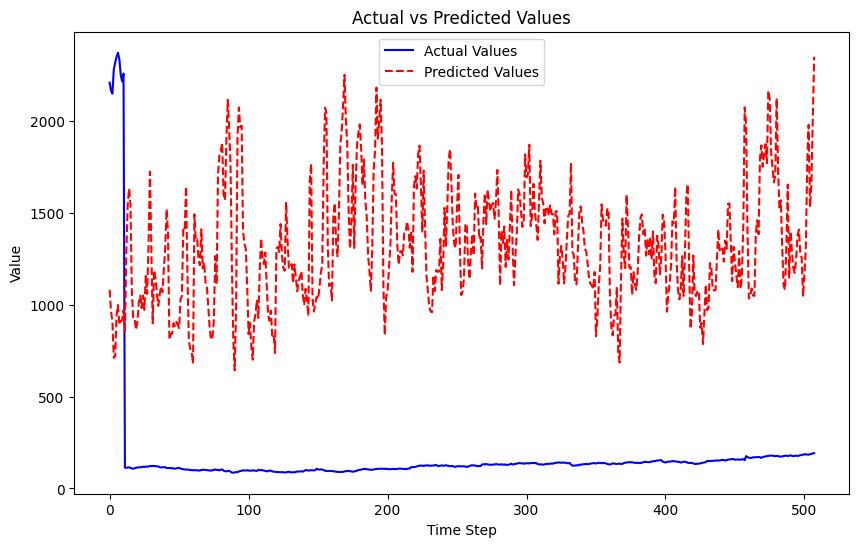

Mean Squared Error (MSE): 1559327.8947580438
Mean Absolute Error (MAE): 1209.607425872047
R-squared (R^2): -14.955444045539727


In [13]:
# 1. Plotting the predicted vs actual values
def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(10, 6))

    # Plot y_test (Actual values)
    plt.plot(y_test, label="Actual Values", color='blue')

    # Plot y_pred (Predicted values)
    plt.plot(y_pred, label="Predicted Values", color='red', linestyle='dashed')

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Actual vs Predicted Values")
    plt.legend()
    plt.show()

# 2. Calculating and printing standard metrics
def evaluate_model(y_test, y_pred):
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE): {mse}")

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae}")

    # R-squared score (R^2)
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared (R^2): {r2}")

# 3. Call the functions to evaluate and plot
plot_predictions(y_test, y_pred)
evaluate_model(y_test, y_pred)


## ChatGPT blah -- why are the results so bad (from pic and the `create_features` function)

The significant disparity between the actual values (blue line) and predicted values (red line) suggests that the model has not captured the underlying pattern of the time series very well. There are several possible reasons for this:

1. **Feature Engineering**: The way the features are created may not be sufficient to capture the relevant information. The `create_features` function is based on correlation with motifs, which might not be the most informative for the time series you're working with. The feature extraction method could be failing to capture meaningful patterns from the data.

2. **Motif Selection**: The motifs selected from the time series might not be representative of the entire dataset. If the motifs are not capturing the key variations, the similarity scores (correlations) could be misleading, resulting in poor predictions.

3. **Model Complexity**: The Random Forest model might not be the best model for this kind of time series data. Random Forest is generally better for tabular data and might not capture the sequential dependencies in the time series data effectively. Models like ARIMA, LSTM, or even XGBoost may perform better on time series.

4. **Scaling**: If the scale of the time series values is large and the values for the target (`y_test`) and features are not normalized or standardized, this could lead to predictions that are off by a large margin, as the model is not able to handle large variations in the data effectively.

5. **Target Variable Distribution**: It seems the distribution of the target variable (`y_test`) is quite different from the predicted values. This could indicate that the model is overfitting certain patterns in the training set and not generalizing well to the test set.

### Suggested Steps for Improvement:

1. **Change Feature Engineering**: Experiment with different ways to create features. For example, instead of using correlations with motifs, try using lag features, rolling statistics (e.g., moving averages), or Fourier transforms to better capture the time dependencies.

2. **Model Choice**: Consider using a model more suited for time series, such as:
   - Long Short-Term Memory (LSTM) networks or GRU (for deep learning-based approaches).
   - Autoregressive models (ARIMA or SARIMA).
   - XGBoost or LightGBM with time-lagged features.

3. **Normalization**: Try normalizing or standardizing the time series data, especially if the values vary significantly in magnitude. This could help the model in learning better relationships between input features and output values.

4. **Cross-Validation**: Make sure to evaluate your model using time series cross-validation to ensure it performs consistently over different time periods. You can use `TimeSeriesSplit` from `sklearn`.

5. **Grid Search for Hyperparameters**: Perform a grid search to optimize hyperparameters of the Random Forest model (e.g., `max_depth`, `min_samples_split`, etc.) to improve its predictive power.

By addressing these issues, you should be able to significantly improve your model's performance and produce more accurate predictions. Let me know if you'd like help with any of these steps!